In [23]:
import sys
print(sys.path)
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages')
sys.path.append('/mnt/c/MyPrograms/__github/Stabilized_ICA')
sys.path.append('/mnt/c/MyPrograms/__github/scycle/')
sys.path.append('/mnt/c/MyPrograms/Python/_lib/')
print(sys.path)

['/mnt/c/MyPrograms/Python/CellCycle', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/zinovyev/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/zinovyev/.local/lib/python3.7/site-packages/IPython/extensions', '/home/zinovyev/.ipython', '/home/zinovyev/anaconda3/lib/python3.7/site-packages', '/mnt/c/MyPrograms/__github/Stabilized_ICA', '/mnt/c/MyPrograms/__github/scycle/', '/mnt/c/Datas/SingleCellTranscriptomics/sciPlex/', '/mnt/c/Datas/SingleCellTranscriptomics/sciPlex/', '/mnt/c/Datas/SingleCellTranscriptomics/sciPlex/', '/mnt/c/Datas/SingleCellTranscriptomics/sciPlex/', '/home/zinovyev/anaconda3/lib/python3.7/site-packages', '/mnt/c/MyPrograms/__github/Stabilized_ICA', '/mnt/c/MyPrograms/__github/scycle/', '/mnt/c/MyPrograms/__github/Python/_lib/', '/mnt/c/Datas/SingleCellTranscriptomics/sciPlex/']
['/mnt/c/MyPrograms/Python/CellCycle', '/usr/lib/python37.zip', '/usr/li

In [87]:
%load_ext autoreload
%autoreload 2
import importlib

import pandas as pd
import numpy as np
import scanpy as sc
import scycle as cc
import scvelo as sv
import anndata
from sklearn.decomposition import PCA

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

mpl.rcParams['figure.dpi'] = 70

import os

import sys
DATA_PATH = '/mnt/c/Datas/SingleCellTranscriptomics/sciPlex/'
sys.path.append(DATA_PATH)
plt.style.use('dark_background')

from elpigraph_ps_tools import *
import elpigraph


def _smooth_adata_by_pooling(adata, X_embed, n_neighbours=10, copy=False):
    # adata_pooled = adata.copy if copy else adata
    nbrs = NearestNeighbors(n_neighbors=n_neighbours).fit(X_embed)
    distances, indices = nbrs.kneighbors(X_embed)
    adata.X = _smooth_matrix_by_pooling(_get_nd_array(adata.X), indices)
    if "matrix" in adata.layers:
        adata.layers["matrix"] = _smooth_matrix_by_pooling(
            _get_nd_array(adata.layers["matrix"]), indices
        )
    if "spliced" in adata.layers:
        adata.layers["spliced"] = _smooth_matrix_by_pooling(
            _get_nd_array(adata.layers["spliced"]), indices
        )
    if "unspliced" in adata.layers:
        adata.layers["unspliced"] = _smooth_matrix_by_pooling(
            _get_nd_array(adata.layers["unspliced"]), indices
        )

    adata.uns["scycle"] = True


def _smooth_matrix_by_pooling(matrix, indices):
    matrix_pooled = matrix.copy()
    for i in range(len(indices)):
        matrix_pooled[i, :] = np.mean(matrix[indices[i], :], axis=0)
    return matrix_pooled


def _get_nd_array(arr):
    x = None
    if str(type(arr)):
        x = arr
    else:
        x = arr.toarray()
    return x

def calc_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names = np.array(signature_dict[key])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        matrix_sel = matrix[:,inds]
        scores = np.mean(matrix_sel,axis=1)
        scores_dic[key] = scores
    return scores_dic

def find_nonproliferative_cells(adata,estimation_fraction_nonproliferating_cells=0.3, 
                                number_of_nodes=30,max_number_of_iterations = 20,
                               number_of_sigmas=3.0,Mu=1.0):
    all_markers = list(adata.uns['S-phase_genes'])+list(adata.uns['G2-M_genes'])
    Xccm = adata[:,list(set(all_markers)&set(adata.var_names))].X
    cc_score = np.array(list(np.mean(Xccm,axis=1)))

    ind_sorted_prolif = np.argsort(cc_score)
    ind_nonprolif = ind_sorted_prolif[0:int(len(adata)*estimation_fraction_nonproliferating_cells)]
    adata.obs['proliferating'] = np.empty(len(adata)).astype(np.int)
    adata.obs['proliferating'][:] = 1
    adata.obs['proliferating'][ind_nonprolif] = 0
    
    sc.pl.scatter(adata,x='S-phase',y='G2-M',color='proliferating')

    fraction_nonprolif_old = estimation_fraction_nonproliferating_cells

    for i in range(max_number_of_iterations):
        X_elpigraph_training = adata.obs[['S-phase','G2-M']].to_numpy().astype(np.float64)
        u = X_elpigraph_training.copy()
        ind_prolif = np.where(np.array(adata.obs['proliferating'])==1)[0]        
        X_elpigraph_training = X_elpigraph_training[ind_prolif,:]

        egr = elpigraph.computeElasticPrincipalCircle(X_elpigraph_training,number_of_nodes,
                                                      Mu=Mu,drawPCAView=False,verbose=False)
        partition, dists = elpigraph.src.core.PartitionData(X = u, NodePositions = egr[0]['NodePositions'], 
                                                                MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                                SquaredX = np.sum(u**2,axis=1,keepdims=1))

        mndist = np.mean(dists[ind_prolif])
        #plt.hist(dists,bins=100)
        #plt.show()
        #plt.hist(dists[ind_prolif],bins=100)
        #plt.show()        
        intervaldist = np.std(dists[ind_prolif])*number_of_sigmas
        tt1 = np.array(1-adata.obs['proliferating'])
        tt2 = np.zeros(len(tt1)).astype(np.int)
        for k,d in enumerate(dists):
            if d>mndist+intervaldist:
                tt2[k] = 1
        nonprolif_new = np.array(tt1) * np.array(tt2)
        adata.obs['proliferating'] = 1-nonprolif_new
        #adata.obs['dists'] = dists
        #sc.pl.scatter(adata,x='S-phase',y='G2-M',color='dists')
        fraction_nonprolif = 1-np.sum(adata.obs['proliferating'])/len(adata)
        print('\n\n===========\nIteration',i,'Fraction of non-proliferating cells:',fraction_nonprolif,'\n==============\n\n\n')    
        if np.abs(fraction_nonprolif-fraction_nonprolif_old)<0.01:
            break
        fraction_nonprolif_old = fraction_nonprolif
        
def _compute_principal_circle(adata,number_of_nodes=30,n_components = 30):
    #driving_feature = np.array(adata_orig[adata.uns['ind_samples']].obs['total_counts'])
    #driving_feature_weight = 1.0
    #egr, partition, X, Xp = _compute_principal_circle(adata,number_of_nodes=40,
    #                                                  driving_feature=driving_feature,driving_feature_weight=0.1)

    X = adata.X
    X_prolif = adata.X[np.where(adata.obs['proliferating']==1)[0],:]
    #driving_feature = driving_feature[adata.obs[np.where(adata.obs['proliferating']==1)[0]]]

    mn_prolif = np.mean(X_prolif,axis=0)
    pca = PCA(n_components=n_components)
    u = pca.fit_transform(X_prolif)
    v = pca.components_.T
    #X_pca = adata.obsm['X_pca'].astype(np.float64)
    X_elpigraph_training = u.astype(np.float64)
    #std = np.std(X_elpigraph_training)
    #driving_feature = stats.zscore(driving_feature)*std*driving_feature_weight
    #driving_feature = driving_feature.reshape(-1,1)
    #X_elpigraph_training = np.concatenate([X_elpigraph_training,driving_feature],axis=1)
    #print('std=',std)
    #print('std df=',np.std(driving_feature))

    #print(X_elpigraph_training.shape)
    egr = elpigraph.computeElasticPrincipalCircle(X_elpigraph_training,number_of_nodes,Mu=0.2)
    partition, dists = elpigraph.src.core.PartitionData(X = X_elpigraph_training, NodePositions = egr[0]['NodePositions'], 
                                                            MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                            SquaredX = np.sum(X_elpigraph_training**2,axis=1,keepdims=1))
    Xp = (X-mn_prolif)@v
    #number_of_driving_features = driving_feature.shape[1]
    #node_positions_reduced = egr[0]['NodePositions'][:,:-number_of_driving_features]
    nodep = egr[0]['NodePositions']
    partition, dists = elpigraph.src.core.PartitionData(X = Xp, NodePositions = nodep, 
                                                           MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                           SquaredX = np.sum(Xp**2,axis=1,keepdims=1))

    #nodep = egr[0]['NodePositions'][:,:-number_of_driving_features]
    #edges = egr[0]['Edges'][0]
    #X_elpigraph_training = X_elpigraph_training[:,:-number_of_driving_features]
    #egr[0]['NodePositions'] = nodep
    return egr, partition, X_elpigraph_training, Xp


def _compute_principal_curve(adata,number_of_nodes=30, Mu=0.3, Lambda=0.001,n_components=30):
    X = adata.X
    X_prolif = adata.X[np.where(adata.obs['proliferating']==1)[0],:]

    mn_prolif = np.mean(X_prolif,axis=0)
    pca = PCA(n_components=n_components)
    u = pca.fit_transform(X_prolif)
    v = pca.components_.T
    #X_pca = adata.obsm['X_pca'].astype(np.float64)
    
    adata.varm['pc_components_elpigraph'] = v
    adata.varm['mean_point_elpigraph'] = mn_prolif
    
    X_elpigraph_training = u.astype(np.float64)

    egr, starting_node = compute_principal_curve_from_circle(X_elpigraph_training,
                                                             n_nodes=number_of_nodes,
                                                            produceTree=False,Mu=Mu,Lambda=Lambda)

    partition_, dists = elpigraph.src.core.PartitionData(X = X_elpigraph_training, NodePositions = egr[0]['NodePositions'], 
                                                            MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                            SquaredX = np.sum(X_elpigraph_training**2,axis=1,keepdims=1))
    Xp = (X-mn_prolif)@v
    partition_, dists = elpigraph.src.core.PartitionData(X = Xp, NodePositions = egr[0]['NodePositions'], 
                                                            MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                            SquaredX = np.sum(Xp**2,axis=1,keepdims=1))

    nodep = egr[0]['NodePositions']
    edges = egr[0]['Edges'][0]
    return egr, partition_, starting_node,X_elpigraph_training, Xp

def compute_principal_curve_from_circle(X,n_nodes=30,Mu=0.1,Lambda=0.01, produceTree=False):
    egr = elpigraph.computeElasticPrincipalCircle(X,int(n_nodes/2),Mu=Mu)
    nodep = egr[0]['NodePositions']
    edges = egr[0]['Edges'][0]
    partition_, dists = elpigraph.src.core.PartitionData(X = X, NodePositions = nodep, 
                                                            MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                            SquaredX = np.sum(X**2,axis=1,keepdims=1))
    node_sizes = np.array([len(np.where(partition_==i)[0]) for i in range(nodep.shape[0])])
    node_min = np.argmin(node_sizes)
    edges_open = edges.copy()
    k = 0
    starting_node = -1
    while k<edges_open.shape[0]:
        e = edges_open[k,:]
        if (e[0]==node_min)|(e[1]==node_min):
            edges_open = np.delete(edges_open,k,axis=0)
            if e[0]==node_min:
                starting_node = e[1]
            if e[1]==node_min:
                starting_node = e[0]
        else:
            k = k+1
    nodep_open = np.delete(nodep,node_min,axis=0)
    if starting_node>node_min:
        starting_node = starting_node-1
    for e in edges_open:
        if e[0]>node_min:
            e[0]=e[0]-1
        if e[1]>node_min:
            e[1]=e[1]-1
    if produceTree:
        egrl = elpigraph.computeElasticPrincipalTree(X,n_nodes,InitNodePositions=nodep_open,
                                                 InitEdges=edges_open,Lambda=Lambda,Mu=Mu,
                                                 alpha=0.01,FinalEnergy='Penalized')
    else:
        egrl = elpigraph.computeElasticPrincipalCurve(X,n_nodes,InitNodePositions=nodep_open,
                                                 InitEdges=edges_open,Lambda=Lambda,Mu=Mu,
                                                 alpha=0.01,FinalEnergy='Penalized')
    return egrl, starting_node

def subtract_cell_cycle_trajectory(X,partition):
    points = range(X.shape[0])
    r2scores = []
    X1 = X[points,:]
    X_ro = np.zeros((X.shape[0],X.shape[1]))
    partition_points = partition[points]
    inds = {}
    for k in range(len(partition_points)):
        j = partition_points[k][0]
        if not j in inds:
            inds[j] = [k]
        else:
            inds[j].append(k)
    XT = X1.T
    for j in range(X1.shape[0]):
        k = partition_points[j][0]
        ind = np.array(inds[k])
        X_ro[j,:] = (XT[:,j] - np.mean(XT[:,ind],axis=1)).T
    residue_matrix = X1 - X_ro
    residues_var = np.var(residue_matrix,axis=0)
    vrs = np.var(X1,axis=0)
    r2scores = residues_var/vrs
    return X_ro, residue_matrix, r2scores


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
# convert csv to h5ad
df = pd.read_csv('/mnt/c/Datas/SingleCellTranscriptomics/sciPlex/sciPlex2_zero_dose.csv',header=0)
X = df.to_numpy()[:,1:].astype(np.int)
samplenames = list(df[df.columns[0]])
genenames = list(df.columns)[1:]
adata = anndata.AnnData(X = X)
adata.var_names = genenames
adata.obs_names = samplenames
adata.obs_names_make_unique()
adata.var_names_make_unique()
adata.write_h5ad('/mnt/c/Datas/SingleCellTranscriptomics/sciPlex/A549_zero_dose.h5ad',compression='gzip')

In [43]:
adata_orig = sc.read_h5ad('/mnt/c/Datas/SingleCellTranscriptomics/sciPlex/A549_zero_dose.h5ad')
print(adata_orig)

AnnData object with n_obs × n_vars = 3500 × 58347


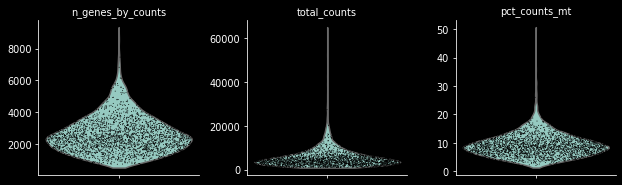

Median total counts = 4654.5
min_count= 1000 max_count= 12000


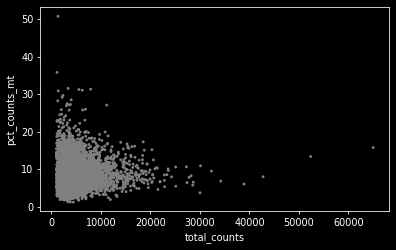

3254 samples pass the count filter
3447  samples pass the mt filter
Samples selected 3201


Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


In [61]:
#-- Pre-process

# standard preprocessing

adata = adata_orig

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

sv.pp.remove_duplicate_cells(adata)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

median_count = np.median(adata.obs['total_counts'])
print('Median total counts =',median_count)
min_count = np.max((median_count/2,5000))

min_count = 1000
max_count = 12000

print('min_count=',min_count,'max_count=',max_count)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
inds1 = np.where((adata.obs['total_counts']>min_count) & (adata.obs['total_counts']<max_count))
inds2 = np.where(adata.obs['pct_counts_mt']<20)
print(len(inds1[0]),'samples pass the count filter')
print(len(inds2[0]),' samples pass the mt filter')
ind_samples = np.intersect1d(inds1[0],inds2[0])
print('Samples selected',len(ind_samples))
adata.uns['ind_samples'] = ind_samples

adata = adata[ind_samples,:]

if False:
    X = adata.X.T
    with open(dataset_name+'_umi.txt','w') as f:
        sample_names = list(adata.obs_names)
        f.write('GENE\t'+'\t'.join(sample_names)+'\n')
        print('Number of genes = ',adata.X.shape[1])
        for i in range(adata.X.shape[1]):
            vals = [str(X[i,k]).replace('.0','') for k in range(X.shape[1])]
            f.write(adata.var_names[i]+'\t'+'\t'.join(vals)+'\n')
    print('Saved.')


sc.pp.normalize_total(adata, target_sum=np.median(adata.obs["total_counts"]))
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=10001,n_bins=20)
ind_genes = np.where(adata.var['highly_variable'])[0]

adata = adata[:,ind_genes]
sc.tl.pca(adata,n_comps=30)
X_pca = adata.obsm['X_pca']

adata_work = adata_orig.copy()[ind_samples,:]
_smooth_adata_by_pooling(adata_work,X_pca,n_neighbours=20)
adata = adata_work
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(adata, target_sum=np.median(adata.obs["total_counts"]))
sc.pp.log1p(adata)
adata = adata[:,ind_genes]
adata.uns['ind_genes'] = ind_genes

sc.tl.pca(adata,n_comps=30)
X_pca = adata.obsm['X_pca']



In [62]:
adata.uns["scycle"] = {}
cc.tl.dimensionality_reduction(adata,method='ica')

idx_g1s = adata.uns['scycle']['find_cc_components']['indices']['G1-S']
adata.uns['S-phase_genes'] = list(adata.var_names[adata.uns['dimRed'].S_[idx_g1s,:]>3])
idx_g2m = adata.uns['scycle']['find_cc_components']['indices']['G2-M']
adata.uns['G2-M_genes'] = list(adata.var_names[adata.uns['dimRed'].S_[idx_g2m,:]>3])
idx_histone = adata.uns['scycle']['find_cc_components']['indices']['Histone']
adata.uns['Histone_IC_genes'] = list(adata.var_names[adata.uns['dimRed'].S_[idx_histone,:]>3])

signature_dict = {'S-phase':adata.uns['S-phase_genes'],
                  'G2-M':adata.uns['G2-M_genes'],
                  'Histone_IC':adata.uns['Histone_IC_genes']}  

sc.pp.highly_variable_genes(adata,n_top_genes=2001,n_bins=20)
ind_genes2k = np.where(adata.var['highly_variable'])[0]
adata2k = adata[:,ind_genes2k]
scores_dic = calc_scores(adata2k,signature_dict)
for score in scores_dic:
    adata.obs[score] = scores_dic[score]


adata.varm['P_dimRed'] = adata.uns['dimRed'].S_.T
adata.uns['dimRed'] = None

-- Dimensionality reduction using ICA...
FastICA from sklearn did not converge due to numerical instabilities - Retrying...
FastICA from sklearn did not converge due to numerical instabilities - Retrying...
-- Done
--- Selected components:
G1-S: 2 (score=7.139491)
G2-M: 1 (score=13.615459)
Histones: 6 (score=1.350722)


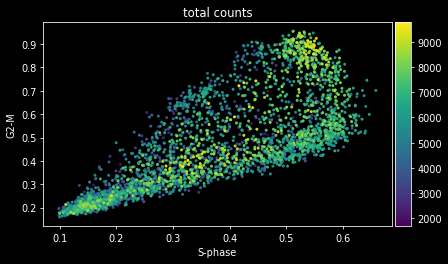

In [63]:
sc.pl.scatter(adata,x='S-phase',y='G2-M',color='total_counts')
plt.show()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


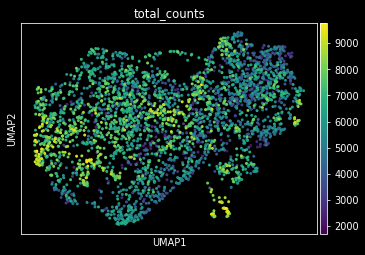

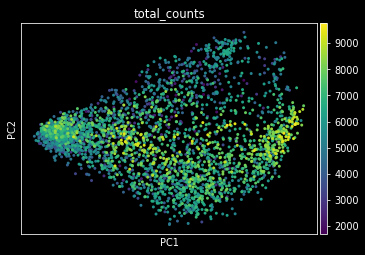

In [78]:
cc_genes = list(adata.uns['S-phase_genes'])+list(adata.uns['G2-M_genes'])+list(adata.uns['Histone_IC_genes'])
adata_cc = adata[:,cc_genes]
sc.tl.pca(adata_cc,n_comps=30)
sc.pp.neighbors(adata_cc, n_neighbors=10)
sc.tl.umap(adata_cc)
sc.pl.umap(adata_cc,color='total_counts')
sc.pl.pca(adata_cc,color='total_counts')

In [118]:
print(cc_genes)

['BRCA1', 'MRE11', 'DEPDC1B', 'HDAC9', 'POLQ', 'MCM10', 'ASPM', 'SLC25A40', 'WDR62', 'MCM6', 'UNG', 'POLD3', 'RBL1', 'ORC1', 'CLSPN', 'SRPK1', 'MCM5', 'POLE2', 'TRIM9', 'CEP128', 'MYBL2', 'TTI1', 'E2F1', 'CEP152', 'LIG1', 'FBXL20', 'NEIL3', 'FBXO5', 'MCM3', 'HMGCS1', 'PRKD3', 'SRSF7', 'MASTL', 'CIT', 'TUBA1B', 'STIL', 'HJURP', 'HIST1H1D', 'PKMYT1', 'MIS18BP1', 'GINS2', 'NUP210', 'PCNA', 'SLF1', 'DOCK10', 'USP37', 'BRIP1', 'KIAA0319', 'DNA2', 'ZGRF1', 'SLC7A1', 'DIAPH3', 'TICRR', 'COPS3', 'SSH2', 'ITGB3BP', 'DTL', 'MMS22L', 'CDCA5', 'HAUS6', 'CCDC82', 'NPAT', 'NCAPD3', 'CENPU', 'SPC25', 'JAZF1', 'ATAD2', 'PAXIP1', 'GALNT14', 'FANCC', 'KIAA1524', 'ZNF704', 'ZNF367', 'E2F7', 'MCM7', 'PLEKHA7', 'PCLAF', 'CDT1', 'C19orf48', 'TK1', 'RRM2', 'IQCB1', 'EXO1', 'POLE', 'TOP3A', 'DCTPP1', 'PLD5', 'GPC6', 'SLC35F3', 'WWOX', 'KIF18B', 'FANCA', 'ARHGAP11B', 'CENPP', 'XRCC2', 'RAD54B', 'ZNF43', 'EMP2', 'AC073529.1', 'ZFPM2-AS1', 'LINC01572', 'AC016205.1', 'PAF1', 'ANLN', 'TACC3', 'DEPDC1', 'DEPDC1B', 

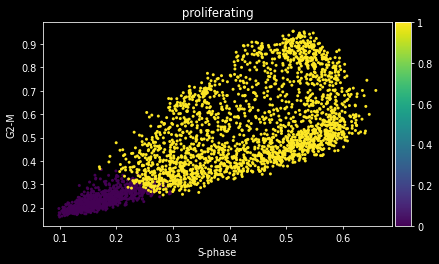

The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
2 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  30  nodes on  2241  points and  2  dimensions
Nodes =  3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||30	0.003	30	30	30	0	0	0	0.0017	0.0016	0.959	0.9626	0.0006	0.0007	0.0221	0.6631	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
0.6587  seconds elapsed


Iteration 0 Fraction of non-proliferating cells: 0.29240862230552955 





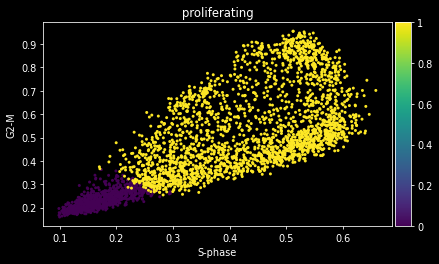

In [82]:
find_nonproliferative_cells(adata,number_of_sigmas=1.0)
sc.pl.scatter(adata,x='S-phase',y='G2-M',color='proliferating')

In [84]:
adata_cc.obs['proliferating'] = adata.obs['proliferating']
print(adata_cc)

AnnData object with n_obs × n_vars = 3201 × 292
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'S-phase', 'G2-M', 'Histone_IC', 'proliferating'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'ind_samples', 'scycle', 'log1p', 'ind_genes', 'dimRed', 'S-phase_genes', 'G2-M_genes', 'Histone_IC_genes', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_dimRed', 'X_pca_scycle', 'X_cc', 'X_umap'
    varm: 'PCs', 'P_dimRed'
    obsp: 'distances', 'connectivities'


(2265, 5)
The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
5 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  30  nodes on  2265  points and  5  dimensions
Nodes =  3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||30	1.8552	30	30	30	0	0	0	1.6413	1.6136	0.8042	0.8075	0.1173	0.0966	2.8974	86.9221	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
0.7818  seconds elapsed


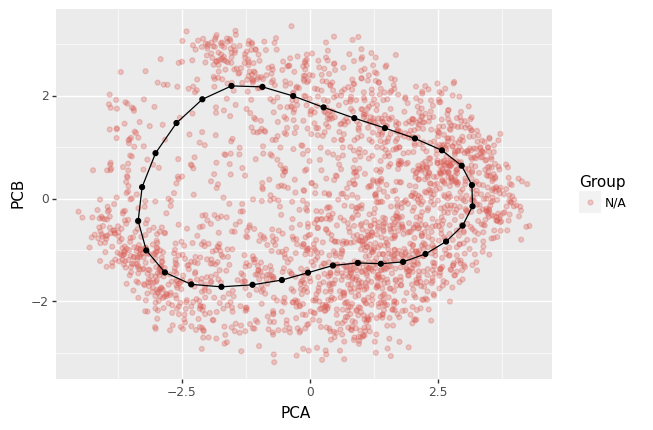

[<ggplot: (8753752209125)>]


In [98]:
import elpigraph

#X = adata.X
#X = adata.obs[['S-phase','G2-M']].to_numpy()
X = adata_cc.obsm['X_pca']
X_prolif = X[np.where(adata.obs['proliferating']==1)[0],:]

number_of_nodes=30
n_components = 5

mn_prolif = np.mean(X_prolif,axis=0)
pca = PCA(n_components=n_components)
u = pca.fit_transform(X_prolif)
v = pca.components_.T
#X_pca = adata.obsm['X_pca'].astype(np.float64)
X_elpigraph_training = u.astype(np.float64)
print(X_elpigraph_training.shape)
egr = elpigraph.computeElasticPrincipalCircle(X_elpigraph_training,number_of_nodes,Mu=0.3)
partition, dists = elpigraph.src.core.PartitionData(X = X_elpigraph_training, NodePositions = egr[0]['NodePositions'], 
                                                        MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                        SquaredX = np.sum(X_elpigraph_training**2,axis=1,keepdims=1))
Xp = (X-mn_prolif)@v
partition, dists = elpigraph.src.core.PartitionData(X = Xp, NodePositions = egr[0]['NodePositions'], 
                                                        MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                        SquaredX = np.sum(Xp**2,axis=1,keepdims=1))


nodep = egr[0]['NodePositions']
edges = egr[0]['Edges'][0]

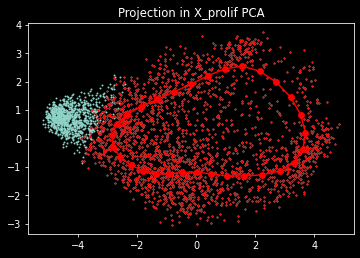

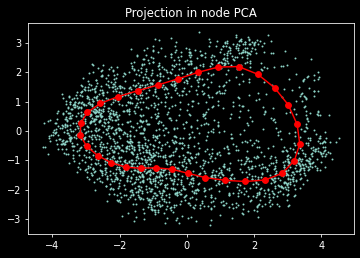

In [117]:
mn_nodes = np.mean(nodep,axis=0)
pca = PCA(n_components=n_components)
u_nodes = pca.fit_transform(nodep)
v_nodes = pca.components_.T
u_node_proj = (X_elpigraph_training-mn_nodes)@v_nodes
u_all = (X-mn_prolif)@v

#driving_feature = list(adata_cc.obs['total_counts'])

plt.scatter(u_all[:,0],u_all[:,1],s=1)
plt.scatter(u[:,0],u[:,1],s=1,c='r')
plt.plot(nodep[:,0],nodep[:,1],'ro')
for e in edges:
    plt.plot([nodep[e[0],0],nodep[e[1],0]],[nodep[e[0],1],nodep[e[1],1]],'r-')
plt.title('Projection in X_prolif PCA')
plt.show()

plt.scatter(u_node_proj[:,0],u_node_proj[:,1],s=1)
plt.plot(u_nodes[:,0],u_nodes[:,1],'ro')
for e in edges:
    plt.plot([u_nodes[e[0],0],u_nodes[e[1],0]],[u_nodes[e[0],1],u_nodes[e[1],1]],'r-')
plt.title('Projection in node PCA')
plt.show()